<div style="text-align:center"><span style="color:black; font-family:Times New Roman; font-size:3em;"> Cervix type classification </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Introduction </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;padding-left:3em;padding-right:3em;"> In this project, I developed Machine Learning algorithms to classify women cervix types based on cervical images provided by Kaggle (https://www.kaggle.com/c/intel-mobileodt-cervical-cancer-screening/data). The goal of the Kaggle competition ‘Cervical Cancer Screening’ is to identify a woman’s cervix type based on images. Correctly identifying a woman’s cervix type can provide an effective treatment for cervical cancer. There are three different types of cervix in this dataset, which are all considered as ‘not cancerous’.  A cervix type can be classified by its transformation zone location which is not easily identified by healthcare providers. Therefore, an algorithm-aided decision is needed to improve the efficiency of classifying cervix types. 
<br \>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
I attempted to achieve best results by implementing and evaluating two classifiers. One is to use logistic regression to classify images with different image feature extraction techniques. The second approach is to use convolutional neural network (CNN), which shows incredibly better performance than logistic regression model. 
 </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Data Preprocessing </span></div>

In [90]:
import glob
import mahotas as mh
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pandas import DataFrame, Series
import cv2
from cv2 import imread
from cv2 import imshow
from cv2 import resize
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder

In [107]:
def make_dataframe(folder, imageformat):
    Class=[]
    ID=[]
    filename=[]
    for file_name in glob.glob('{}*'.format(folder)):
        label_name=file_name.split('\\')[-1]
        image=glob.glob(folder+label_name+'/*.{}'.format(imageformat))
        for f in image:
            id_label=f.split('\\')[-1][:-4]
            ID.append(id_label)
            Class.append(label_name)
            filename.append(f)
    df=DataFrame(data={'filename':filename, 'ID':ID, 'Class':Class})
    return df

In [108]:
df=make_dataframe('train/','jpg')
df.head()

,Class,ID,filename
0,Type_1,0,train/Type_1\0.jpg
1,Type_1,10,train/Type_1\10.jpg
2,Type_1,1013,train/Type_1\1013.jpg
3,Type_1,1014,train/Type_1\1014.jpg
4,Type_1,1019,train/Type_1\1019.jpg


In [105]:
def plot_images(df):
    fig, ax=plt.subplots(nrows=3,ncols=3, figsize=(12,12))
    for j in range(0,3):
        for i in range(0,3):
            files_for_each_class=df[df['Class']==df['Class'].unique()[i]]['filename'] 
            ax[j,i].imshow(mh.imread(files_for_each_class.values[j]))
            ax[j,i].set_title(files_for_each_class.values[j].split('/')[1])
            ax[j,i].grid()

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">   The images are downloaded from Kaggle. The representative images of three cervix types are shown below. 

 </span></div>

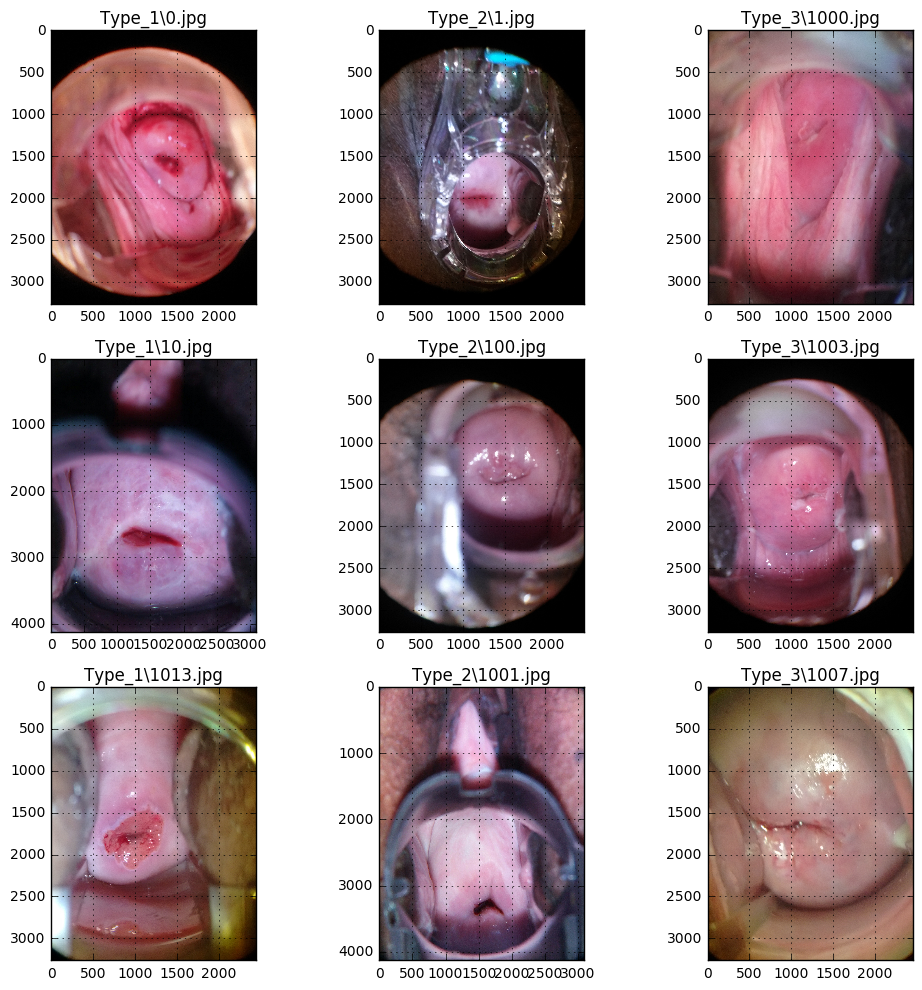

In [109]:
plot_images(df)

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Preprocessing step 1 : Cervix segmentation </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Preprocessing is the first step of image analysis. The purpose of preprocessing is to make recognition of image objects easier and improve the quality of the image being processed. In order to enhance accuracy of cervix classification, I want to remove the speculums that might be shown in images. Since the pixels on a speculum location are darker than those on a cervix area, thresholding is used to convert a color image to a bi-level image by using an optimal threshold. Each pixel in a bi-level image is set to either 0 or 1. After thresholding, an image is chopped by finding the largest rectangular area with pixel value 1. Therefore, those pixels that contain a cervix object is extracted and separated from a speculum.  The algorithm theory of fining the largest rectangular area in a bi-level image is explained in https://www.youtube.com/watch?v=g8bSdXCG-lA, https://www.youtube.com/watch?v=VNbkzsnllsU.



 </span></div>

In [6]:
def chop_image(image):
    maxarea=0
    row=np.zeros(image.shape[1])
    maxarea_row_positions=[0,0]
    maxarea_column_positions=[0,0]
    column_position=[]
    length=[]
    for i in range(image.shape[0]):#loop over each row
        for j in range(image.shape[1]):#loop over each column in a row
            if image[i,j]>0:
                row[j]+=image[i,j]
            elif image[i,j]==0:
                row[j]=0
    
        count=0
        for j in range(image.shape[1]):
            if row[j] > 0:
                if maxarea < row[j]:
                    maxarea = row[j]
                    maxarea_column_positions=[j,j]
                    maxarea_row_positions=[i-row[j]+1, i]
                column_position.append(j)
                length.append(row[j])
                count+=1
                if j == image.shape[1]-1:
                    if maxarea < count*np.min(length):
                        maxarea = count*np.min(length)
                        maxarea_column_positions=[column_position[0],column_position[-1] ]
                        maxarea_row_positions=[i-np.min(length)+1, i]
                    column_position=[]
                    length=[]
            elif row[j] == 0:
                if row[j-1]>0 and j!=0:
                    if maxarea < count*np.min(length):
                        maxarea = count*np.min(length)
                        maxarea_column_positions=[column_position[0],column_position[-1] ]
                        maxarea_row_positions=[i-np.min(length)+1, i]
                    count=0
                    column_position=[]
                    length=[]
    return maxarea_row_positions, maxarea_column_positions
        

In [7]:
def preprocess_image(im, xmargin,ymargin,a):
    img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    _, thresh =cv2.threshold(gray, (gray.max())/a, gray.max(), cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    main_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]
    ff = np.zeros((gray.shape[0],gray.shape[1]), 'uint8') 
    cv2.drawContours(ff, main_contour,-1,1, 5)
    ff_mask = np.zeros((gray.shape[0]+2,gray.shape[1]+2), 'uint8')
    cv2.floodFill(ff, ff_mask, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 1)

    [y1,y2], [x1,x2]=chop_image(ff)
    return img, img[np.where(y1-ymargin>0, y1-ymargin,0):y2+ymargin,\
                    np.where(x1-xmargin>0, x1-xmargin,0):np.where(x2+xmargin<img.shape[1], x2+xmargin,img.shape[1]-1)]


In [ ]:
for i in range(0,3):
    classtype=i
    for j in range(0,len(df[df['Class']==df['Class'].unique()[i]])):
        filenumber=j
        files_for_each_class=df[df['Class']==df['Class'].unique()[classtype]]['filename']
        im=cv2.imread(files_for_each_class.values[filenumber])
        original, altered=preprocess_image(im, 0,0,3)#(horizontal, vertical)
        alter_image=altered
        mh.imsave("train_cut/{}/{}.jpg".format(df['Class'].unique()[classtype],\
                                               df[df['Class']==df['Class'].unique()[classtype]]['ID'].values[filenumber]),\
                  alter_image)

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> The representative chopped images of three cervix types are shown below. A cervix object is well extracted from a source image. 

 </span></div>

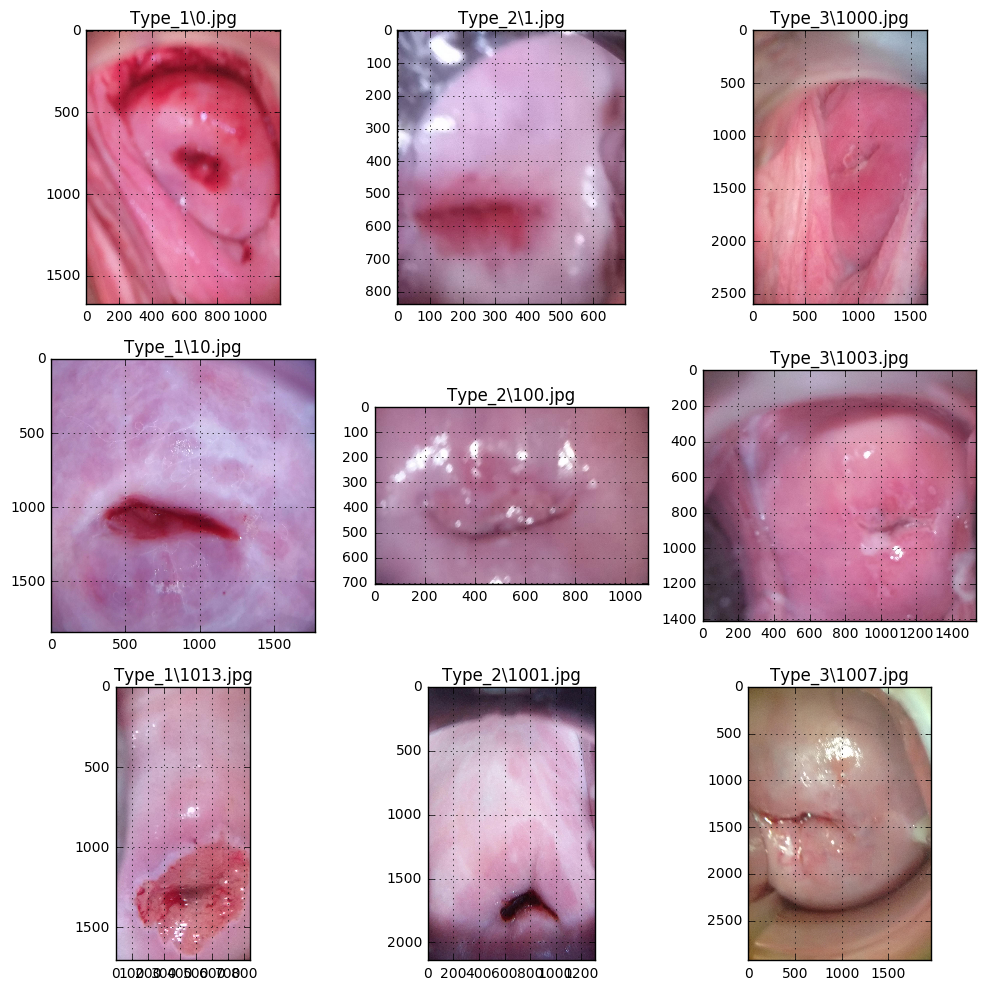

In [46]:
df_cut=make_dataframe('train_cut/','jpg')
plot_images(df_cut)

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Preprocessing step 2 : Resize image to 256 x 256 for logistic regression modeling</span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The second step of image preprocessing is to ensure the image size consistent across the dataset. Since the chopped images generated from the first preprocessing step have different sizes, I use a two-step approach for resizing the chopped images. First, I resize images by fixing either width or height and preserving the original aspect ratio. If the width of an image is shorter (longer) than the height, the width size (height size) is normalized to 256. This is done by the function ‘scale_colorimage_step1’. After that, the image chopping is applied to a longer dimension of an image so that the image size becomes 256 x 256. The function ‘scale_colorimage_step2’ tries to locate a cervix opening and chop an image along a longer dimension of the image in a such way that critical cervix pixels can be preserved. The final resized 256 x 256 images are saved through the function ‘scale_colorimage_step3’. 
 
 </span></div>

In [41]:
def scale_colorimage_step1(im):
    if im.shape[0] > im.shape[1]:
        scaled_size = (256, int(im.shape[0]*256/im.shape[1]))
    else:
        scaled_size = (int(im.shape[1]*256/im.shape[0]),256)
    scaled_im = cv2.resize(im, dsize=scaled_size) 
    return scaled_im

def scale_colorimage_step2(scaled_im,df_cut):
    ratio=3
    if scaled_im.shape[0] < scaled_im.shape[1]:
        length=len(scaled_im.sum(0))
        profile=scaled_im.sum(0)[length/ratio:-length/ratio]
    else:
        length=len(scaled_im.sum(1))
        profile=scaled_im.sum(1)[length/ratio:-length/ratio]
    min_point=np.argmin(profile)+length/ratio
    if (min_point >= 128) & (length-min_point >= 128):
        end1=min_point-128
        end2=min_point+128
    elif (min_point > 128) & (length-min_point <= 128):
        end1=length-256
        end2=length
    elif (min_point <= 128) & (length-min_point > 128):
        end1=0
        end2=256
    return end1, end2

def scale_colorimage_step3(scaled_im,df_cut,end1, end2,classtype,filenumber):  
    if scaled_im.shape[0] < scaled_im.shape[1]:
        squared_image=scaled_im[:,end1:end2]
    else:
        squared_image=scaled_im[end1:end2,:]
        
    mh.imsave("train_cut_colorscaled/{}/{}.png".format(df_cut['Class'].unique()[classtype],\
                                           df_cut[df_cut['Class']==df_cut['Class'].unique()[classtype]]['ID'].values[filenumber]), \
                squared_image)
    return squared_image
    


In [ ]:
for i in range(0,3):
    print 'This is Type_%d' %i
    classtype=i
    for j in range(0,len(df_cut[df_cut['Class']==df_cut['Class'].unique()[i]])):
        print j
        filenumber=j
        files_for_each_class=df_cut[df_cut['Class']==df_cut['Class'].unique()[classtype]]['filename']       
        im=mh.imread(files_for_each_class.values[j],as_grey=True)
        scaled_im=scale_colorimage_step1(im)
        end1, end2=scale_colorimage_step2(scaled_im,df_cut)
        im=mh.imread(files_for_each_class.values[j])
        scaled_im=scale_colorimage_step1(im)
        squared_image=scale_colorimage_step3(scaled_im,df_cut,end1, end2,classtype,filenumber)
        

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> The representative resized 256x256 images of three cervix types are shown below.

 </span></div>

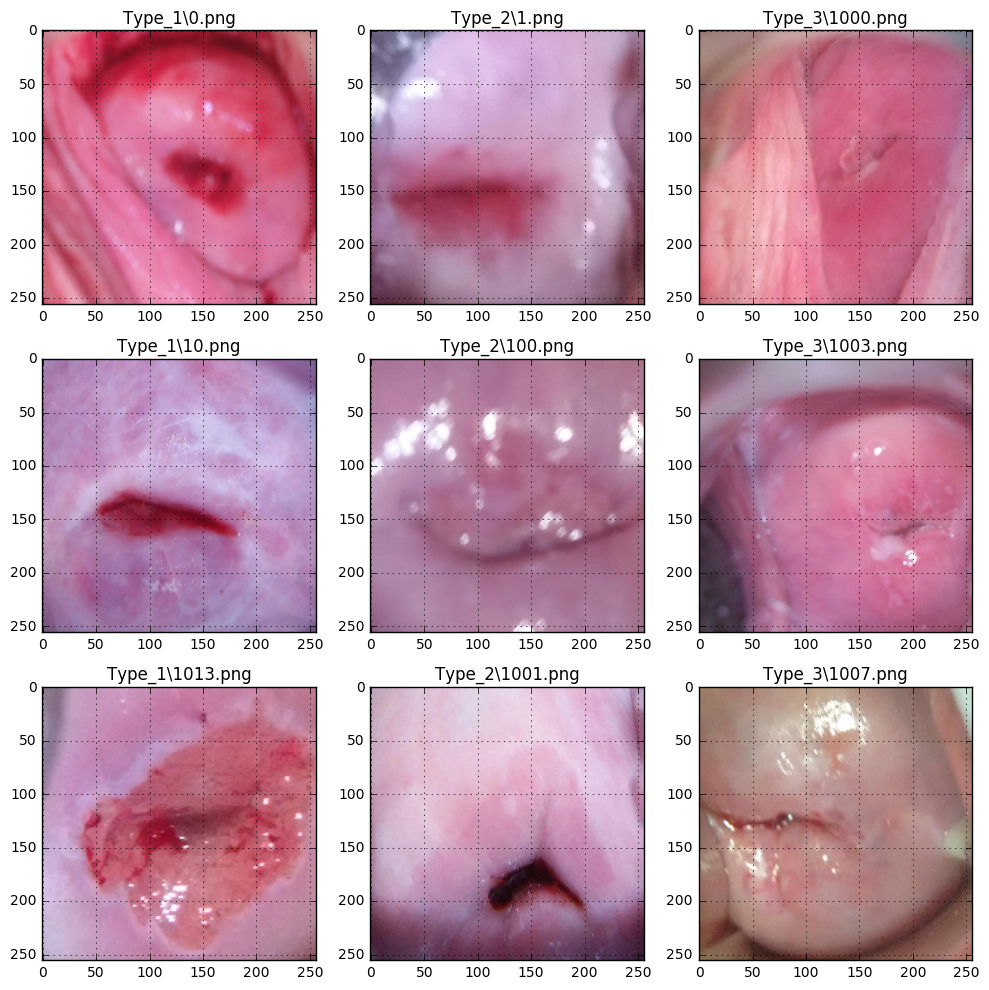

In [71]:
df_cut_colorscaled=make_dataframe('train_cut_colorscaled/','png')
plot_images(df_cut_colorscaled)

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> After filtering out some blurry or empty images, I have 1409 training images. The number of images for each cervix type is listed below. 

 </span></div>

In [94]:
print 'Total sample number in the training set : %d' %(len(df_cut_colorscaled))
print 'The numbers of Type 1 in the training set : %d' %(len(df_cut_colorscaled[df_cut_colorscaled['Class']==df_cut_colorscaled['Class'].unique()[0]]))
print 'The numbers of Type 2 in the training set : %d' %(len(df_cut_colorscaled[df_cut_colorscaled['Class']==df_cut_colorscaled['Class'].unique()[1]]))
print 'The numbers of Type 3 in the training set : %d' %(len(df_cut_colorscaled[df_cut_colorscaled['Class']==df_cut_colorscaled['Class'].unique()[2]]))

Total sample number in the training set : 1409
The numbers of Type 1 in the training set : 754
The numbers of Type 2 in the training set : 239
The numbers of Type 3 in the training set : 416


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Preprocessing step 3 : Label Conversion </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> The labels for three cervix types are converted by LabelEncoder. The label 0 corresponds to the Type 1, 1 for the Type 2 and 2 for the Type 3. 
<br \>
The information of all image file names, file ID, cervix types and class labels is stored in the ‘df_cut_colorscaled’ dataframe. The sample rows of the dataframe have been randomly shuffled and saved in a CSV file ('df_cut_colorscaled.csv') for logistic regression modeling.
 </span></div>

In [89]:
np.random.seed(0)
df_cut_colorscaled=df_cut_colorscaled.reindex(np.random.permutation(df_cut_colorscaled.index))

In [91]:
labelencoder=LabelEncoder()
df_cut_colorscaled['label']=labelencoder.fit_transform(df_cut_colorscaled['Class'].values)
df_cut_colorscaled=df_cut_colorscaled.reset_index(drop=True)
y_train_colorscaled=df_cut_colorscaled['label'].values

In [92]:
df_cut_colorscaled.head(10)
df_cut_colorscaled.to_csv('df_cut_colorscaled.csv', index=False)

,Class,ID,filename,label
0,Type_2,377,train_cut_colorscaled/Type_2\377.png,1
1,Type_2,243,train_cut_colorscaled/Type_2\243.png,1
2,Type_2,227,train_cut_colorscaled/Type_2\227.png,1
3,Type_2,574,train_cut_colorscaled/Type_2\574.png,1
4,Type_1,396,train_cut_colorscaled/Type_1\396.png,0
5,Type_2,133,train_cut_colorscaled/Type_2\133.png,1
6,Type_3,73,train_cut_colorscaled/Type_3\73.png,2
7,Type_3,690,train_cut_colorscaled/Type_3\690.png,2
8,Type_2,1255,train_cut_colorscaled/Type_2\1255.png,1
9,Type_3,892,train_cut_colorscaled/Type_3\892.png,2


<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Preprocessing step 4 : Resize image to 32 x 32 for CNN modeling </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
Using 256×256 images makes the training quite slow for convolutional neural network (CNN). In order to make computation fast and also produce good results, I decide to resize 256×256 images further to 32×32 images for the trade-off between computation speed and accuracy. After resizing, each image input data is expressed as a 3-dimensional matrix of channels x width x height, e.g. 3x32x32. The three channels represent the red, green and blue pixel values. I normalized the 8-bit RGB pixel values  to the range 0 and 1 by dividing each value by the maximum of 255. 
The image input data in the training dataset is saved in ‘x_train_32.pkl’. The output variable is saved in 'y_train.pkl'. 
 </span></div>

In [96]:
def image_resize_256_to_32(df):
    filename=[]
    x_data=[]
    for f in df['filename']:
        image=mh.imread(f)
        if image.shape != (256L, 256L, 3L):
            print f   
        resized = cv2.resize(image, (32, 32))
        x_data.append(resized)
        filename.append(f.split('\\')[-1][:-4] + '.jpg')
    x_data=np.array(x_data, dtype=np.uint8)
    x_data=x_data.transpose((0, 3,1,2)).astype('float32')/255
    print x_data.shape
    return x_data, filename

In [98]:
x_traindata, filename_traindata=image_resize_256_to_32(df_cut_colorscaled)

(1409L, 3L, 32L, 32L)


In [100]:
joblib.dump(x_traindata,'x_train_32.pkl')
joblib.dump(y_train_colorscaled,'y_train.pkl')

['y_train.pkl']

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  
Preprocessing step 5 : prepare the test dataset </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
The test image dataset is downloaded from Kaggle. The test data has 512 images. The test images are preprocessed through chopping and resizing into 32x32 images for CNN prediction. The image input data in the test dataset is saved in 'x_test_32.pkl'. The file names is saved in 'x_test_ID.pkl'.  
 </span></div>

In [75]:
def make_dataframe_for_testdata(folder):
    ID=[]
    filename=[]
    for file_name in glob.glob('{}*'.format(folder)):
        id_label=file_name.split('\\')[-1][:-4]
        ID.append(id_label)
        filename.append(file_name)
    df_test=DataFrame(data={'filename':filename, 'ID':ID})
    return df_test

In [77]:
df_test=make_dataframe_for_testdata('test/')
print 'Total sample number in the test set : %d' %(len(df_test))

Total sample number in the test set : 512


In [ ]:
for filenumber in range(0,len(df_test)):
    files=df_test['filename']   
    im=cv2.imread(files.values[filenumber])
    original, altered=preprocess_image(im, 0,0,3)#(horizontal, vertical)
    alter_image=altered
    mh.imsave("test_cut/{}.jpg".format(df_test['ID'].values[filenumber]),alter_image)

In [78]:
df_test_cut=make_dataframe_for_testdata('test_cut/')

In [ ]:
for filenumber in range(0,len(df_test_cut)):
    files=df_test_cut['filename']       
    im=mh.imread(files.values[j],as_grey=True)
    scaled_im=scale_colorimage_step1(im)
    end1, end2=scale_colorimage_step2(scaled_im,df_test_cut)
    im=mh.imread(files.values[j])
    scaled_im=scale_colorimage_step1(im)
    squared_image=scale_colorimage_step3(scaled_im,df_test_cut,end1, end2,filenumber)

In [99]:
df_test_scaled=make_dataframe_for_testdata('test_cut_colorscaled/')
x_testdata, filename_testdata=image_resize_256_to_32(df_test_scaled)
joblib.dump(x_testdata,'x_test_32.pkl')
joblib.dump(np.array(filename_testdata),'x_test_ID.pkl') 

(512L, 3L, 32L, 32L)


['x_test_ID.pkl']